# **Bitcoin Price Prediction**

---
In this section of our project we aim to predict the price of Bitcoin using 'LSTM' networks. The data includes historical Bitcoin price data, as well as sentiment scores obtained through two distinct approaches: VADER and BERT.

# **Import Required Libraries**

---



In [ ]:
# Ignore execution-time warning messages
import warnings
warnings.filterwarnings("ignore")

# Importing module for connecting Google Drive
from google.colab import drive

# Importing the pandas library to manipulate data and numerical operations
import pandas as pd
import numpy as np

# Importing MinMaxScaler to normalize features.
from sklearn.preprocessing import MinMaxScaler

# Importing Matplotlib for visualisation creation
import matplotlib.pyplot as plt

# Statistical analysis utilizing statsmodels
import statsmodels.api as sm

# Importing mean_absolute_error and mean_squared_error  for performance evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Utilization of the square root function in mathematical operations
from math import sqrt

# For developing neural networks using the Sequential class
from keras.models import Sequential

# Dense layer import for neural network architecture
from keras.layers import Dense

# LSTM layer incorporation for constructing LSTM models
from keras.layers import LSTM

# Using EarlyStopping to control model training
from keras.callbacks import EarlyStopping

# Importing the datetime package for time-related calculations
from datetime import datetime

# Importing  datetime for date data management
from datetime import date

# Importing the dates module of Matplotlib for date formatting in visualizations.
import matplotlib.dates as mdates

In [ ]:
drive.mount('/content/drive')

base_path = '/content/drive/My Drive/MyData/'

Sentiment_Scores = pd.read_csv(base_path + 'Sentiment_Scores_Dataset.csv')
combined_data = pd.read_csv(base_path + 'combined_data.csv')

Mounted at /content/drive


In [ ]:
combined_data.head()

,date,open,high,low,close,Volume BTC,Volume USD
0,31/12/2017 23:59,13913.28,13913.28,13867.18,13880.00,0.591748,8213.456549
1,31/12/2017 23:58,13913.26,13953.83,13884.69,13953.77,1.398784,19518.309660
2,31/12/2017 23:57,13908.73,13913.26,13874.99,13913.26,0.775012,10782.944290
3,31/12/2017 23:56,13827.00,13908.69,13827.00,13859.58,0.666459,9236.841134
4,31/12/2017 23:55,13825.05,13825.05,13825.05,13825.05,0.065501,905.560130


# **Convert to Daily Price Data**
---



In [ ]:
# Convert to datetime and extract only the date
combined_data['date'] = pd.to_datetime(combined_data['date']).dt.date

# Group by date and compute the average of close prices for each day
Daily_Price = combined_data.groupby('date')['close'].mean()

print(Daily_Price.head())


date
2017-01-01     977.276060
2017-01-02     970.869729
2017-01-03    1206.258632
2017-01-04    1077.520590
2017-01-05    1376.713319
Name: close, dtype: float64


# **Convert to Daily Sentiment Data**

---



In [ ]:
Sentiment_Scores.drop(['VADER_Sentiment_Scores','BERT_Sentiment_Scores'], axis=1, inplace=True)

In [ ]:
# Convert to datetime and extract only the date
Sentiment_Scores['date'] = pd.to_datetime(Sentiment_Scores['date']).dt.date
Sentiment_Scores.head(5)

,date,compound,BERT_Compound
0,2018-04-04,0.7184,0.011698
1,2018-01-18,-0.6619,-0.030943
2,2018-06-03,0.4404,0.200639
3,2017-04-05,0.9192,-0.019981
4,2018-04-01,-0.5200,-0.019931


# **Check the duplicates**

---



In [ ]:
duplicates_count = Sentiment_Scores[Sentiment_Scores['date'].duplicated(keep=False)].shape[0]

print(f"There are {duplicates_count} duplicated date entries in the dataset.")

There are 83231 duplicated date entries in the dataset.


In [ ]:
# Aggregating by sum
daily_sentiment = Sentiment_Scores.groupby('date').agg({
    'compound': 'sum',
    'BERT_Compound': 'sum'
}).reset_index()

print(daily_sentiment)

            date  compound  BERT_Compound
0     2015-08-07    0.8477       0.066474
1     2015-08-08    0.9925       0.024525
2     2015-08-09    0.9204       0.075311
3     2015-08-10   -0.8444      -0.220224
4     2015-08-13    0.6028       0.197171
...          ...       ...            ...
1300  2019-03-30    0.8442       0.063358
1301  2019-04-02    0.7357      -0.088832
1302  2019-04-04    0.8268       0.736143
1303  2019-04-05    0.8475       0.102021
1304  2019-04-06    1.7264       0.703655

[1305 rows x 3 columns]


In [ ]:
duplicates_count = daily_sentiment[daily_sentiment['date'].duplicated(keep=False)].shape[0]

print(f"There are {duplicates_count} duplicated date entries in the dataset.")

There are 0 duplicated date entries in the dataset.


# **Merge the Daily Datasets**

---



In [ ]:
# Merge the dataframes based on 'date'
merged_df = pd.merge(Daily_Price, daily_sentiment, on='date', how='inner')

In [ ]:
merged_df.shape

(823, 4)

In [ ]:
merged_df.head(5)

,date,close,compound,BERT_Compound
0,2017-01-01,977.276060,4.2240,0.658844
1,2017-01-02,970.869729,4.8402,-2.750831
2,2017-01-03,1206.258632,10.9275,-2.501940
3,2017-01-04,1077.520590,5.5076,-1.165282
4,2017-01-05,1376.713319,9.1549,0.491668


# **Predict Bitcoin Price Using Historical Price**

---
In this part, the price of Bitcoin will be predicted only based on the Historical Price Dataset (Daily_Price).

# **Split the Data to Train/Test**

---



In [ ]:
d0 = date(2017, 1, 1)
d1 = date(2018, 9, 12)
delta = d1 - d0
days_look = delta.days + 1
print(days_look)

d0 = date(2018, 9, 20)
d1 = date(2019, 4, 5)
delta = d1 - d0
days_from_train = delta.days + 1
print(days_from_train)

d0 = date(2018, 9, 12)
d1 = date(2018, 9, 20)
delta = d1 - d0
days_from_end = delta.days + 1
print(days_from_end)

620
198
9


In [ ]:
df_train= Daily_Price[len(Daily_Price)-days_look-days_from_end:len(Daily_Price)-days_from_train]
df_test= Daily_Price[len(Daily_Price)-days_from_train:]

print(len(df_train), len(df_test))

431 198


# **Bitcoin Price Breakdown**

---



In [ ]:
working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
working_data['date'] = pd.to_datetime(working_data['date'])
working_data = working_data.set_index('date')

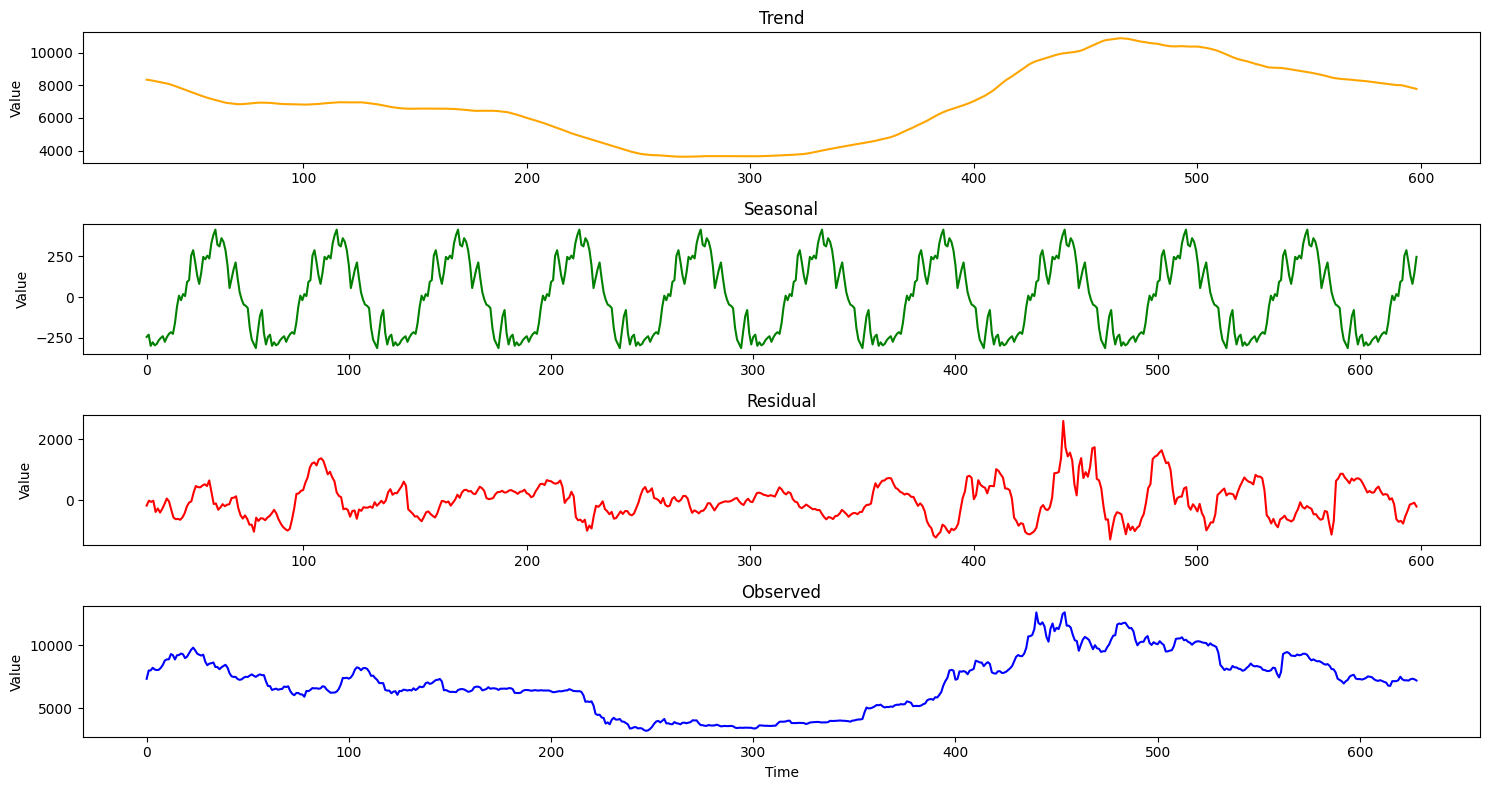

In [ ]:
# Decompose the series
s = sm.tsa.seasonal_decompose(working_data.close.values, period=60)
# Plotting
plt.figure(figsize=(15, 8))
# Plotting the trend
plt.subplot(4, 1, 1)
plt.plot(s.trend, color='orange')
plt.title('Trend')
plt.ylabel('Value')
# Plotting the seasonal component
plt.subplot(4, 1, 2)
plt.plot(s.seasonal, color='green')
plt.title('Seasonal')
plt.ylabel('Value')
# Plotting the residual component
plt.subplot(4, 1, 3)
plt.plot(s.resid, color='red')
plt.title('Residual')
plt.ylabel('Value')
# Plotting the observed data
plt.subplot(4, 1, 4)
plt.plot(s.observed, color='blue')
plt.title('Observed')
plt.xlabel('Time')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:
df_train = working_data[:-198]
df_test = working_data[-198:]

In [ ]:
print(len(df_train), len(df_test))

431 198


In [ ]:
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

# scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

# reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

# **Train the LSTM Model Using Historical Price**

---




In [ ]:
# Initialize sequential model, add 2 stacked LSTM layers and densely connected output neuron
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Epoch 1/100
27/27 [==============================] - 9s 34ms/step - loss: 0.1504 - val_loss: 0.1359
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0345 - val_loss: 0.1281
Epoch 3/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0214 - val_loss: 0.0233
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0065
Epoch 5/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 6/100
27/27 [==============================] - 0s 6ms/step - loss: 8.2998e-04 - val_loss: 0.0085
Epoch 7/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0074
Epoch 8/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0058
Epoch 9/100
27/27 [==============================] - 0s 6ms/step - loss: 9.3040e-04 - val_loss: 0.0054
Epoch 10/100
27/27 [==============================] - 0s 6ms/step - loss: 9.0101e-04 - val_loss: 0.0

In [ ]:
# add one additional data point to align shapes of the predictions and true labels
X_test = np.append(X_test, scaler.transform(working_data.iloc[-1][0].reshape(-1, 1)))
X_test = np.reshape(X_test, (len(X_test), 1, 1))

# get predictions and then make some transformations to be able to calculate RMSE properly in USD
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

7/7 [==============================] - 1s 3ms/step


# **Visualizing Actual vs. Predicted Prices Over Time**

---




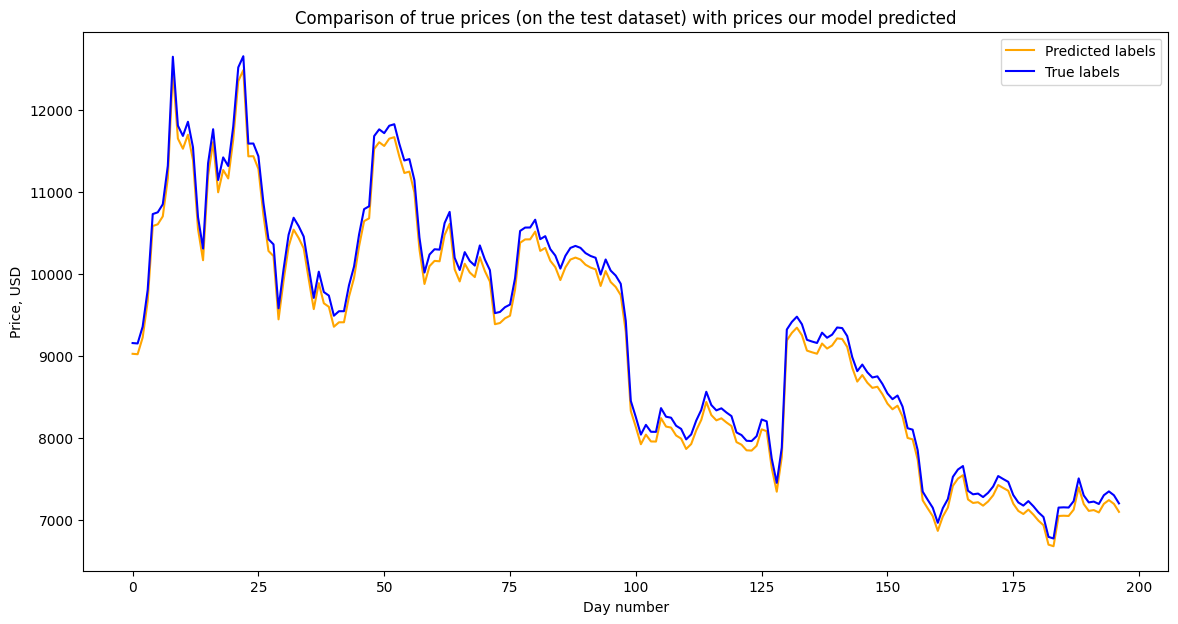

In [ ]:
# Extract data from variables
x = np.arange(0, len(prediction2_inverse), 1)
y1 = prediction2_inverse
y2 = Y_test2_inverse

# Create a new figure
plt.figure(figsize=(14,7))

# Plot the data
plt.plot(x, y1, label='Predicted labels', color='orange')
plt.plot(x, y2, label='True labels', color='blue')

# Title and labels
plt.title('Comparison of true prices (on the test dataset) with prices our model predicted')
plt.xlabel('Day number')
plt.ylabel('Price, USD')
plt.legend()

# Display the plot
plt.show()

# **Visualizing Actual vs. Predicted Prices by dates**

---



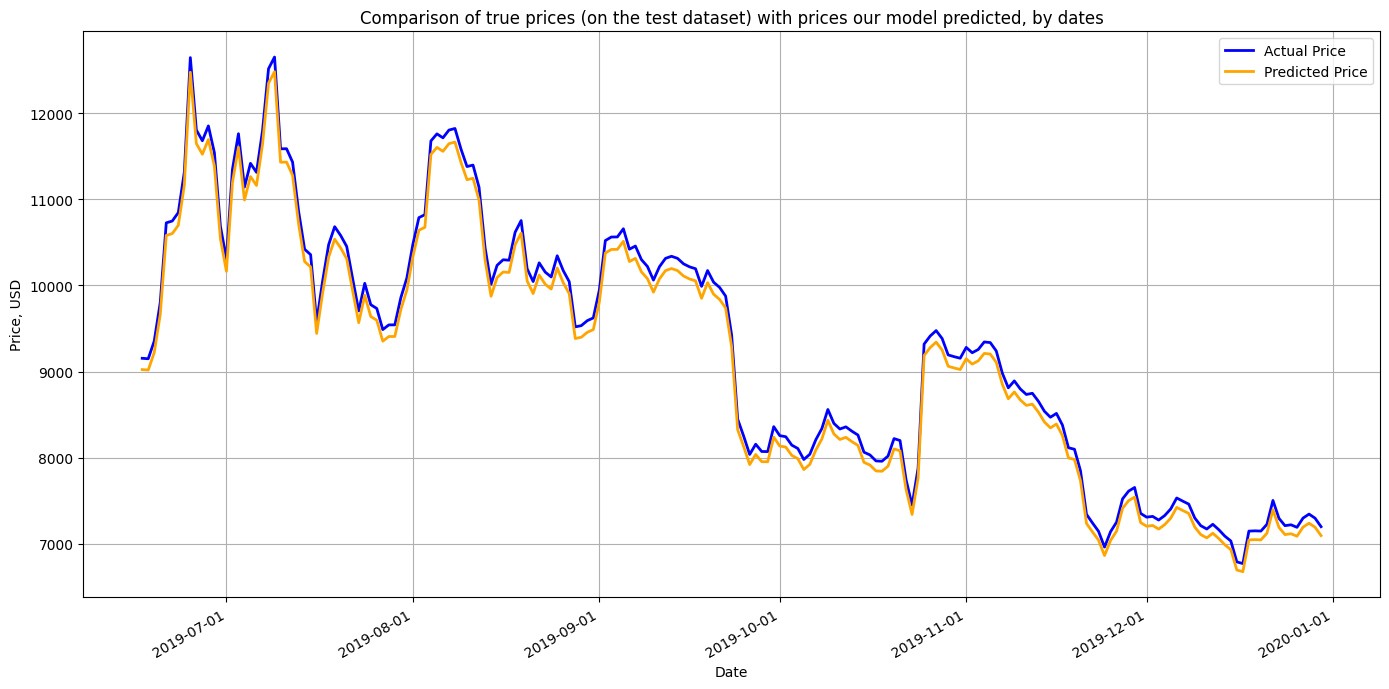

In [ ]:
# Retrieve the dates corresponding to the test dataset from the Daily_Price dataframe.
Test_Dates = Daily_Price[len(Daily_Price)-days_from_train:].index
# Remove the last date from the Test_Dates list.
Test_Dates = Test_Dates[:-1]

# Extract data
x = Test_Dates
y1 = Y_test2_inverse
y2 = prediction2_inverse
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(x, y1, label='Actual Price', color='blue', linewidth=2)
plt.plot(x, y2, label='Predicted Price', color='orange', linewidth=2)
# Formatting date on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
# Title and labels
plt.title('Comparison of true prices (on the test dataset) with prices our model predicted, by dates')
plt.xlabel('Date')
plt.ylabel('Price, USD')
plt.legend()
plt.grid(True)
# Show plot
plt.tight_layout()
plt.show()

# **Evaluate The Model by RMSE & MAE for  Historical Price**

---



In [ ]:
# Calculate RMSE
RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)
# Calculate MAE
MAE = mean_absolute_error(Y_test2_inverse, prediction2_inverse)
print('Test MAE: %.3f' % MAE)

Test RMSE: 131.348
Test MAE: 130.180


# **Predict Bitcoin Price Using Historical Price With VADER Sentiments**

---



In [ ]:
df_vader = merged_df.drop(columns=['BERT_Compound'])

# **Split to Train/Test for VADER**

In [ ]:
df_vader_train = df_vader[:-198]
df_vader_test = df_vader[-198:]

In [ ]:
def create_lookback(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Extract values and reshape
training_set_vader = df_vader_train.iloc[:, 1:].values   # Get columns 'close' and 'VADER_Sentiment_Scores'
test_set_vader = df_vader_test.iloc[:, 1:].values       # Get columns 'close' and 'VADER_Sentiment_Scores'

# Scale datasets
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_vader = scaler.fit_transform(training_set_vader)
test_set_vader = scaler.transform(test_set_vader)

# Create datasets suitable for time series forecasting
look_back = 1
X_train_vader, Y_train_vader = create_lookback(training_set_vader, look_back)
X_test_vader, Y_test_vader = create_lookback(test_set_vader, look_back)
print(X_train_vader.shape)
print(X_test_vader.shape)

# Reshape datasets for LSTM model requirements
X_train_vader = np.reshape(X_train_vader, (X_train_vader.shape[0], X_train_vader.shape[1], 2))  # 2 for two features
X_test_vader = np.reshape(X_test_vader, (X_test_vader.shape[0], X_test_vader.shape[1], 2))      # 2 for two features

(624, 1, 2)
(197, 1, 2)


In [ ]:
print(X_train_vader.shape)
print(X_test_vader.shape)

(624, 1, 2)
(197, 1, 2)


# **Train the LSTM Model Using Historical Price and VADER Sentiments**

---




In [ ]:
# LSTM model definition
model_vader = Sequential()
model_vader.add(LSTM(256, return_sequences=True, input_shape=(X_train_vader.shape[1], X_train_vader.shape[2])))  # Input shape: (look_back, number of features)
model_vader.add(LSTM(256))
model_vader.add(Dense(1))

# Compile and fit the model
model_vader.compile(loss='mean_squared_error', optimizer='adam')
history_vader = model_vader.fit(X_train_vader, Y_train_vader, epochs=100, batch_size=16, shuffle=False,
                                validation_data=(X_test_vader, Y_test_vader),
                                callbacks=[EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Epoch 1/100
39/39 [==============================] - 4s 23ms/step - loss: 0.0217 - val_loss: 0.0050
Epoch 2/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0362 - val_loss: 0.0184
Epoch 3/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0271 - val_loss: 0.0040
Epoch 4/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0141 - val_loss: 2.5346e-04
Epoch 5/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 7.8520e-04
Epoch 6/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0098 - val_loss: 4.7728e-04
Epoch 7/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0102 - val_loss: 2.7841e-04
Epoch 8/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0106 - val_loss: 1.9203e-04
Epoch 9/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 2.0877e-04
Epoch 10/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0119 - v

In [ ]:
# Predict using the LSTM model
predicted_stock_price = model_vader.predict(X_test_vader)

# Rescale the predicted values back to original scale
predicted_stock_price = scaler.inverse_transform(np.hstack((predicted_stock_price, X_test_vader[:, 0, 1:].reshape(-1, 1))))

# Extract only the predicted stock price (without the sentiment scores)
predicted_stock_price = predicted_stock_price[:, 0]


7/7 [==============================] - 1s 3ms/step


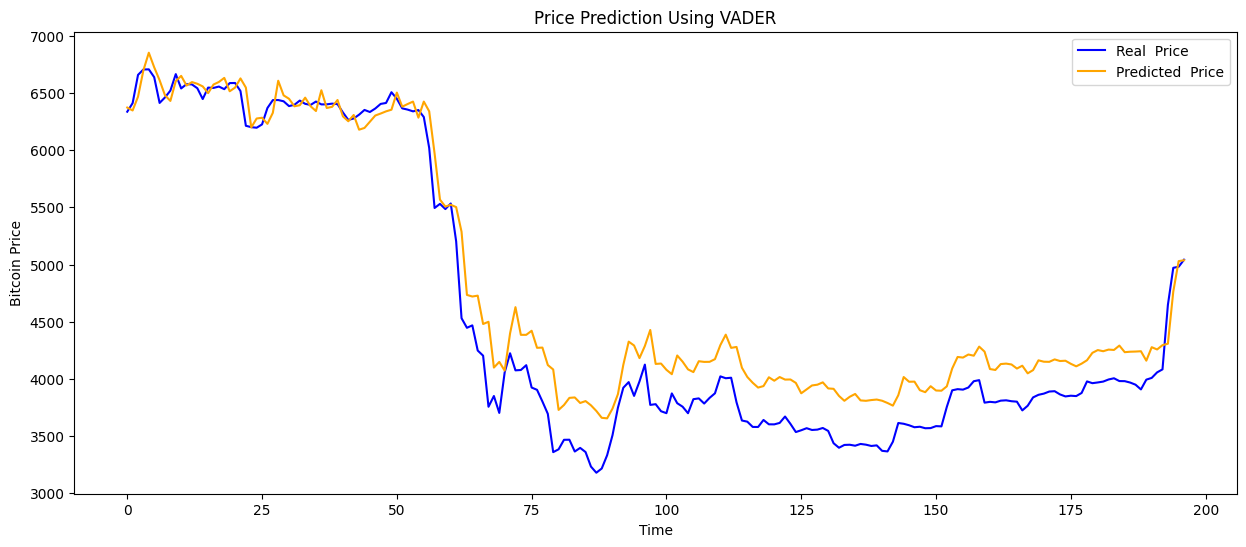

In [ ]:
real_stock_price = df_vader_test.iloc[1:, 1].values   # Starting from index 1 because of the look_back

plt.figure(figsize=(15, 6))
plt.plot(real_stock_price, color = 'blue', label = 'Real  Price')
plt.plot(predicted_stock_price, color = 'orange', label = 'Predicted  Price')
plt.title('Price Prediction Using VADER')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()


# **Evaluate the Model Using RMSE & MAE (VADER)**

---



In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print(f"Mean Absolute Error (MAE): {mae}")


Root Mean Squared Error (RMSE): 303.8529470372707
Mean Absolute Error (MAE): 258.80940933094104


# **Predict Bitcoin Price Using Historical Price With BERT Sentiments**

---



In [ ]:
df_bert = merged_df.drop(columns=['compound'])


In [ ]:
df_bert_train = df_bert[:-198]
df_bert_test = df_bert[-198:]


In [ ]:
# Extract values and reshape
training_set_bert = df_bert_train.iloc[:, 1:].values   # Get columns 'close' and 'BERT_Sentiment_Scores'
test_set_bert = df_bert_test.iloc[:, 1:].values       # Get columns 'close' and 'BERT_Sentiment_Scores'

# Scale datasets
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_bert = scaler.fit_transform(training_set_bert)
test_set_bert = scaler.transform(test_set_bert)

# Create datasets suitable for time series forecasting
look_back = 1
X_train_bert, Y_train_bert = create_lookback(training_set_bert, look_back)
X_test_bert, Y_test_bert = create_lookback(test_set_bert, look_back)
print(X_train_bert.shape)
print(X_test_bert.shape)

# Reshape datasets for LSTM model requirements
X_train_bert = np.reshape(X_train_bert, (X_train_bert.shape[0], X_train_bert.shape[1], 2))  # 2 for two features
X_test_bert = np.reshape(X_test_bert, (X_test_bert.shape[0], X_test_bert.shape[1], 2))      # 2 for two features


(624, 1, 2)
(197, 1, 2)


In [ ]:
print(X_train_bert.shape)
print(X_test_bert.shape)

(624, 1, 2)
(197, 1, 2)


# **Train the LSTM Model Using Historical Price and BERT Sentiments**

---

In [ ]:
# LSTM model definition
model_bert = Sequential()
model_bert.add(LSTM(256, return_sequences=True, input_shape=(X_train_bert.shape[1], X_train_bert.shape[2])))  # Input shape: (look_back, number of features)
model_bert.add(LSTM(256))
model_bert.add(Dense(1))

# Compile and fit the model
model_bert.compile(loss='mean_squared_error', optimizer='adam')
history_bert = model_bert.fit(X_train_bert, Y_train_bert, epochs=100, batch_size=16, shuffle=False,
                                validation_data=(X_test_bert, Y_test_bert),
                                callbacks=[EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])


Epoch 1/100
39/39 [==============================] - 4s 23ms/step - loss: 0.0261 - val_loss: 0.0108
Epoch 2/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0446 - val_loss: 0.0329
Epoch 3/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0377 - val_loss: 0.0180
Epoch 4/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0231 - val_loss: 0.0073
Epoch 5/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0141 - val_loss: 0.0018
Epoch 6/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 8.4087e-04
Epoch 7/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0111 - val_loss: 8.3370e-04
Epoch 8/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0114 - val_loss: 9.2448e-04
Epoch 9/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0117 - val_loss: 0.0010
Epoch 10/100
39/39 [==============================] - 0s 5ms/step - loss: 0.0120 - val_loss: 0.0

In [ ]:
# Predict using the LSTM model
predicted_stock_price = model_bert.predict(X_test_bert)

# Rescale the predicted values back to original scale
predicted_stock_price = scaler.inverse_transform(np.hstack((predicted_stock_price, X_test_bert[:, 0, 1:].reshape(-1, 1))))

# Extract only the predicted stock price (without the sentiment scores)
predicted_stock_price = predicted_stock_price[:, 0]

7/7 [==============================] - 1s 3ms/step


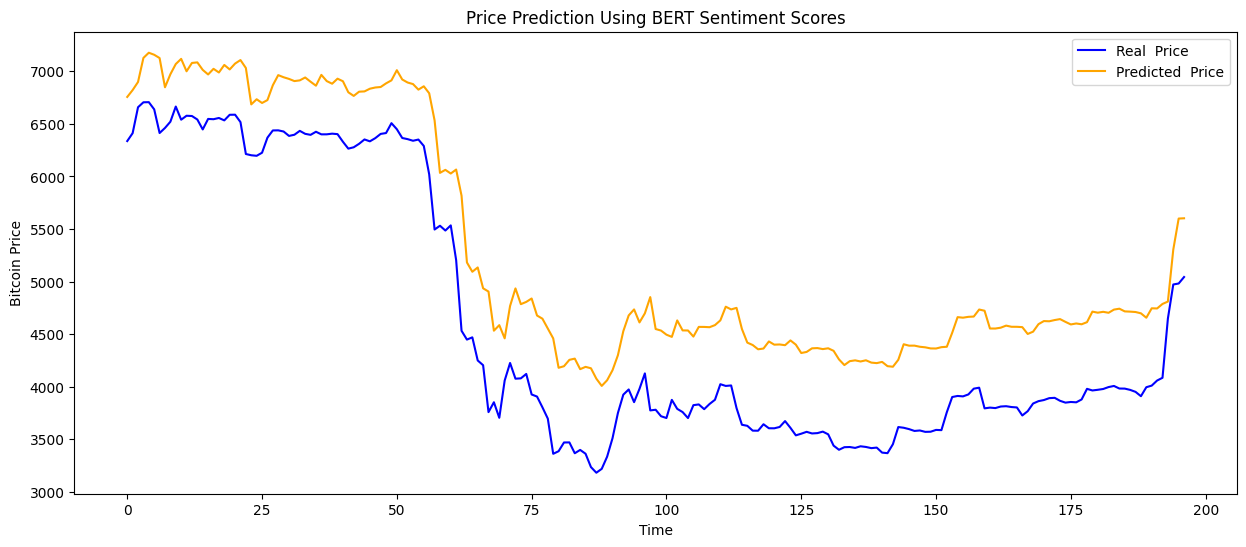

In [ ]:
real_stock_price = df_bert_test.iloc[1:, 1].values   # Starting from index 1 because of the look_back

plt.figure(figsize=(15, 6))
plt.plot(real_stock_price, color = 'blue', label = 'Real  Price')
plt.plot(predicted_stock_price, color = 'orange', label = 'Predicted  Price')
plt.title('Price Prediction Using BERT Sentiment Scores')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

# **Evalute the Model Using RMSE & MAE (BERT)**

---



In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE): 705.3375710776388
Mean Absolute Error (MAE): 684.8531192613166
